In [1]:
!pip install transformers

DEPRECATION: pytorch-lightning 1.5.4 has a non-standard dependency specifier torch>=1.7.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
from tqdm import tqdm
tqdm.pandas()

import numpy as np
import os



import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


import matplotlib.pyplot as plt

import transformers
from transformers import AutoModel, BertTokenizer#, BertForSequenceClassification

import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [3]:
df = pd.read_csv('L.csv' ,delimiter=';', encoding='cp1251')

df['Target'] = df['Group'] #+'/'+ df['Cat']


# df= df[:50]



#this needed for one hot encoding
amount_of_classes = len(df['Target'].unique())


encoder = sklearn.preprocessing.LabelBinarizer()
y = encoder.fit_transform(df['Target'])

#print(encoder.inverse_transform(y))
y = pd.DataFrame(y)
# df = pd.concat([df, y], axis=1)
columns_to_convert = [int(i) for i in range(amount_of_classes)]


df['Target_2'] = df['Cat'] 
amount_of_classes_2 = len(df['Target_2'].unique())
encoder_2 = sklearn.preprocessing.LabelBinarizer()
y_2 = encoder_2.fit_transform(df['Target_2'])
y_2 = pd.DataFrame(y_2, columns=[str(i)+'_1' for i in range(amount_of_classes_2)])
df = pd.concat([df, y, y_2], axis=1)
columns_to_convert_2 = [str(i)+'_1' for i in range(amount_of_classes_2)]
# print(df[columns_to_convert_2[0]])

print('amount', amount_of_classes, amount_of_classes_2)

amount 22 97


In [4]:
train, test = train_test_split(df, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.25, random_state=42)


train_x = train['Desc']
train_y = train[columns_to_convert+columns_to_convert_2].to_numpy()
# train_y_2 = train[columns_to_convert_2].to_numpy()

test_x = test['Desc']
test_y = test[columns_to_convert+columns_to_convert_2].to_numpy()
# test_y_2 = test[columns_to_convert_2].to_numpy()


val_x = val['Desc']
val_y = val[columns_to_convert+columns_to_convert_2].to_numpy()
# val_y_2 = val[columns_to_convert_2].to_numpy()

In [5]:
#в статье они на глазок определяли какието токены, я в другом блокноте
#такое делал, у меня наверное десять получилось, но можно попробовать дргуое

In [6]:
tokenizer = BertTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")
bert = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased-sentence")
bert.to(device)


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
 

In [7]:

'''
new_vocabulary = {}

for i in tqdm(range(int(len(df)))):
    deb = str(df['Desc'][i]).split()
    for j in deb:
        if len(tokenizer.encode(j)) > 3:
            count = new_vocabulary.get(j, 0)
            new_vocabulary.update({j:count+1})

new_vocabulary = (sorted(new_vocabulary.items(), key=lambda item: -item[1]))
to_learn = []
for i in new_vocabulary:
    if i[1]>5:
        to_learn.append(i[0])
to_learn = set(to_learn) - set(tokenizer.vocab.keys())
tokenizer.add_tokens(list(to_learn))
bert.resize_token_embeddings(len(tokenizer))
'''

"\nnew_vocabulary = {}\n\nfor i in tqdm(range(int(len(df)))):\n    deb = str(df['Desc'][i]).split()\n    for j in deb:\n        if len(tokenizer.encode(j)) > 3:\n            count = new_vocabulary.get(j, 0)\n            new_vocabulary.update({j:count+1})\n\nnew_vocabulary = (sorted(new_vocabulary.items(), key=lambda item: -item[1]))\nto_learn = []\nfor i in new_vocabulary:\n    if i[1]>5:\n        to_learn.append(i[0])\nto_learn = set(to_learn) - set(tokenizer.vocab.keys())\ntokenizer.add_tokens(list(to_learn))\nbert.resize_token_embeddings(len(tokenizer))\n"

In [8]:
tokens_train = tokenizer.batch_encode_plus(train_x.astype('str'), max_length=10,
                                          padding='max_length', truncation = True)
tokens_val = tokenizer.batch_encode_plus(val_x.astype('str'), max_length=10,
                                          padding='max_length', truncation = True)
tokens_test = tokenizer.batch_encode_plus(test_x.astype('str'), max_length=10,
                                          padding='max_length', truncation = True)


train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_y)
# print(train_y)
# train_y_2 = torch.tensor(train_y_2)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_y)
# test_y_2 = torch.tensor(test_y_2)

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_y)
# val_y_2 = torch.tensor(val_y_2)

In [9]:
batch_size = 8

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size = batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size = batch_size)

test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size = batch_size)


# !

In [10]:
for param in bert.parameters():
    param.requires_grad = False
    

    
class BERT_Arch(nn.Module):

    def __init__(self):#, bert):
        super(BERT_Arch, self).__init__()
        #self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768,512)
        self.fc2 = nn.Linear(512,amount_of_classes)
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, cls_hs):#, sent_id, mask):
        #cls_hs is pooler output in docs
       #_, cls_hs = self.bert(sent_id, attention_mask = mask, return_dict = False)
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [11]:
epochs = 30
cross_entropy = nn.CrossEntropyLoss()

model = BERT_Arch()

model = model.to(device)
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr= 1e-3)

model_1_path = os.path.join('..', 'model', 'model1.pt')
model_1_path

C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


'..\\model\\model1.pt'

In [12]:
def evaluate():
    model.eval()
    total_loss, total_accuracy = 0,0
    total_preds = []

    for step, batch in tqdm(enumerate(val_dataloader), total = len(val_dataloader)):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        
        labels = labels[:amount_of_classes]

        with torch.no_grad():
            _, cls_hs = bert(sent_id, mask, return_dict = False)
            preds = model(cls_hs)

            labels = torch.argmax(labels, dim=1)

            loss = cross_entropy(preds, labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

    avg_loss = total_loss / len(val_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)

    return avg_loss, total_preds

In [13]:
def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds = []

    for step, batch in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        batch = [r.to(device) for r   in batch]
        sent_id, mask, labels = batch
        
        labels = labels[:amount_of_classes]
        
        model.zero_grad()
        _, cls_hs = bert(sent_id, mask, return_dict = False)
        preds = model(cls_hs)

        labels = torch.argmax(labels, dim=1)

 
        loss = cross_entropy(preds, labels)
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)
        

    avg_loss = total_loss / len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)

    return avg_loss, total_preds

In [14]:
best_valid_loss = float('inf')

train_losses = []
valid_losses = []

for epoch in range(epochs):
    print('\n Epoch{:} / {:}'.format(epoch+1, epochs))

    train_loss, _ = train()
    valid_loss, _ = evaluate()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_1_path)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f'\nTraining loss: {train_loss:.3f}')
    print(f'Validation loss: {valid_loss:.3f}')


 Epoch1 / 30


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 87.80it/s]



Training loss: 0.164
Validation loss: 0.140

 Epoch2 / 30


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 87.91it/s]



Training loss: 0.118
Validation loss: 0.115

 Epoch3 / 30


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 87.93it/s]



Training loss: 0.110
Validation loss: 0.092

 Epoch4 / 30


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 87.64it/s]



Training loss: 0.105
Validation loss: 0.082

 Epoch5 / 30


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 88.23it/s]



Training loss: 0.098
Validation loss: 0.088

 Epoch6 / 30


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 88.23it/s]



Training loss: 0.093
Validation loss: 0.086

 Epoch7 / 30


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 88.15it/s]



Training loss: 0.093
Validation loss: 0.108

 Epoch8 / 30


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 88.03it/s]



Training loss: 0.089
Validation loss: 0.079

 Epoch9 / 30


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 87.88it/s]



Training loss: 0.086
Validation loss: 0.080

 Epoch10 / 30


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 87.86it/s]



Training loss: 0.083
Validation loss: 0.095

 Epoch11 / 30


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 87.78it/s]



Training loss: 0.081
Validation loss: 0.080

 Epoch12 / 30


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 87.86it/s]



Training loss: 0.080
Validation loss: 0.110

 Epoch13 / 30


 62%|████████████████████████████████████████████████▌                             | 2383/3825 [00:30<00:18, 77.39it/s]


KeyboardInterrupt: 

In [15]:

model.load_state_dict(torch.load(model_1_path))

<All keys matched successfully>

In [18]:
#my evaluation after training

model.eval()
model.to(device)
count_true = 0
count_total = 0
for step, batch in tqdm(enumerate(test_dataloader), total = len(test_dataloader)):
    batch = [t.to(device) for t in batch]
    sent_id, mask, labels = batch
    labels= labels[:amount_of_classes]
    
    with torch.no_grad():
        _, cls_hs = bert(sent_id, mask, return_dict=False)
        preds = model(cls_hs)
        preds = torch.argmax(preds, dim=1)
        preds = preds.cpu().numpy()
        labels = torch.argmax(labels, dim=1)
        labels = list((labels).cpu().numpy())
#         print(labels==preds, preds, labels)
    
    for index in range(len(preds)):
        count_total += 1
        if preds[index] == labels[index]:
            count_true += 1
            

print(count_true/count_total)
        
        

100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 86.57it/s]

0.9797999607766229


In [19]:
print(count_true/count_total)
# 3 epochs on group only is 0.97734
# 0.921455 on 30 epochs with bert training

0.9797999607766229


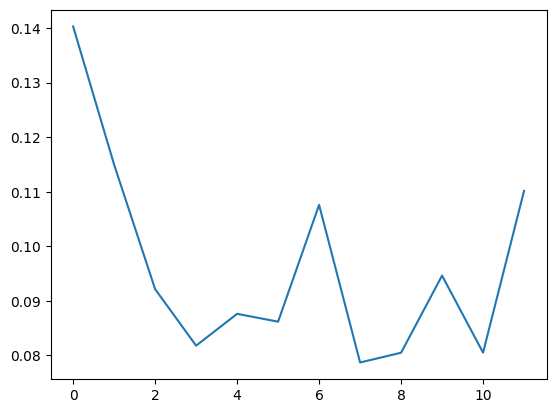

In [20]:
plt.plot(valid_losses)
plt.show()

# category classification

In [21]:
for param in bert.parameters():
    param.requires_grad = False

class second(nn.Module):

    def __init__(self, amount_of_classes, amount_of_classes_2):
        super(second, self).__init__()

        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768 + amount_of_classes ,1024)
        self.fc2 = nn.Linear(1024,amount_of_classes_2)
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, cls_hs, target_1):
        #cls_hs is pooler output in docs
        #_, cls_hs = self.bert(sent_id, attention_mask = mask, return_dict = False)
#         print(cls_hs.shape, target_1.shape)
        concated = (torch.cat((cls_hs, target_1), 1))
        x = self.fc1(concated)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [26]:
epochs = 20

cross_entropy = nn.CrossEntropyLoss()
# cross_entropy = nn.KLDivLoss(reduction="batchmean")

model_second = second(amount_of_classes, amount_of_classes_2)

model_second = model_second.to(device)
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr= 1e-3)

model_2_path = os.path.join('..', 'model', 'model2.pt')

In [27]:
def evaluate_second():
    model_second.eval()
    total_loss, total_accuracy = 0,0
    total_preds = []

    for step, batch in tqdm(enumerate(val_dataloader), total = len(val_dataloader)):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        
        #my bad code
        labels= list(labels.cpu().numpy())
        corr_answ = []
        for label in labels:
            label = list(label[amount_of_classes:])
            corr_answ.append(label.index(1))
        corr_answ = torch.tensor(corr_answ).to(device)
            

        with torch.no_grad():
            _, cls_hs = bert(sent_id, attention_mask = mask, return_dict = False)

            target_1 = model(cls_hs)
            preds = model_second(cls_hs, target_1)

            #labels = torch.argmax(labels, dim=1)

            loss = cross_entropy(preds, corr_answ)

            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)
            
            
            


    avg_loss = total_loss / len(val_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)

    return avg_loss, total_preds


In [28]:
def train_second():
    model_second.train()
    total_loss, total_accuracy = 0, 0
    total_preds = []

    for step, batch in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        batch = [r.to(device) for r in batch]
        sent_id,mask,labels = batch
        
        labels= list(labels.cpu().numpy())
        corr_answ = []
        for label in labels:
            label = list(label[amount_of_classes:])
            corr_answ.append(label.index(1))
        corr_answ = torch.tensor(corr_answ).to(device)
        
#         print('correct answers (indexes):', corr_answ)
#         print('labels:', labels)
        
        model_second.zero_grad()
        _, cls_hs = bert(sent_id, attention_mask = mask, return_dict = False)
        target_1 = model(cls_hs)
        
        preds = model_second(cls_hs, target_1)

#         for i in range(len(corr_answ)):
            
        
        loss = cross_entropy(preds, corr_answ)

        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)
        

    avg_loss = total_loss / len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)

    return avg_loss, total_preds

In [29]:
best_valid_loss = float('inf')

train_losses = []
valid_losses = []

for epoch in range(epochs):
    print('\n Epoch{:} / {:}'.format(epoch+1, epochs))

    train_loss, _ = train_second()
    valid_loss, _ = evaluate_second()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        print('saving...')
        torch.save(model_second.state_dict(), model_2_path)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f'\nTraining loss: {train_loss:.3f}')
    print(f'Validation loss: {valid_loss:.3f}')


 Epoch1 / 20


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:15<00:00, 84.72it/s]


saving...

Training loss: 3.932
Validation loss: 3.605

 Epoch2 / 20


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 85.94it/s]


saving...

Training loss: 3.559
Validation loss: 3.473

 Epoch3 / 20


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 85.85it/s]


saving...

Training loss: 3.466
Validation loss: 3.376

 Epoch4 / 20


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 86.12it/s]


saving...

Training loss: 3.414
Validation loss: 3.345

 Epoch5 / 20


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 86.02it/s]


saving...

Training loss: 3.380
Validation loss: 3.312

 Epoch6 / 20


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 86.28it/s]


saving...

Training loss: 3.358
Validation loss: 3.295

 Epoch7 / 20


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 86.16it/s]


saving...

Training loss: 3.345
Validation loss: 3.281

 Epoch8 / 20


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 86.15it/s]



Training loss: 3.322
Validation loss: 3.284

 Epoch9 / 20


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 86.11it/s]



Training loss: 3.309
Validation loss: 3.281

 Epoch10 / 20


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 86.27it/s]


saving...

Training loss: 3.293
Validation loss: 3.228

 Epoch11 / 20


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 86.14it/s]



Training loss: 3.288
Validation loss: 3.249

 Epoch12 / 20


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 85.94it/s]


saving...

Training loss: 3.270
Validation loss: 3.195

 Epoch13 / 20


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 86.19it/s]


saving...

Training loss: 3.243
Validation loss: 3.182

 Epoch14 / 20


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 86.18it/s]


saving...

Training loss: 3.225
Validation loss: 3.174

 Epoch15 / 20


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 86.21it/s]


saving...

Training loss: 3.222
Validation loss: 3.167

 Epoch16 / 20


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 86.22it/s]



Training loss: 3.210
Validation loss: 3.199

 Epoch17 / 20


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 86.14it/s]



Training loss: 3.207
Validation loss: 3.181

 Epoch18 / 20


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 86.11it/s]


saving...

Training loss: 3.202
Validation loss: 3.163

 Epoch19 / 20


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 85.98it/s]



Training loss: 3.196
Validation loss: 3.173

 Epoch20 / 20


100%|██████████████████████████████████████████████████████████████████████████████| 1275/1275 [00:14<00:00, 86.27it/s]

saving...

Training loss: 3.197
Validation loss: 3.151


In [30]:

model_second.load_state_dict(torch.load(model_2_path))

<All keys matched successfully>

In [31]:
#my evaluation after training

model_second.eval()
model_second.to(device)
count_true = 0
count_total = 1
for step, batch in tqdm(enumerate(test_dataloader), total = len(test_dataloader)):
    batch = [t.to(device) for t in batch]
    sent_id, mask, labels = batch
#     print('eto', len(labels))
    #labels= labels[amount_of_classes:amount_of_classes_2]
    
    with torch.no_grad():
        _, cls_hs = bert(sent_id, attention_mask = mask, return_dict = False)
        target_1 = model(cls_hs)
        preds=model_second(cls_hs, target_1)
        preds = torch.argmax(preds, dim=1)
        preds = preds.cpu().numpy()
#         labels = torch.argmax(labels, dim=1)
#         labels = list((labels).cpu().numpy())
#         print(labels==preds, preds, labels)
    
    labels = list(labels)
#     print(min(preds), preds)
    if max(preds >= 98):
        print('aaa', preds)
        continue
    
    for index in range(len(preds)):        
        correct = list(labels[index][amount_of_classes:].cpu().numpy()).index(1)
#         print(correct)
#         print(preds[index])
        count_total += 1
        tmp1 = [0] * amount_of_classes_2
#         print(preds)
#         tmp1[preds[index]] = 1
        
        tmp2 = [0] * amount_of_classes_2
        tmp2[correct] = 1
        tmp1, tmp2 = torch.tensor([tmp1]), torch.tensor([tmp2])
        #print(tokenizer.convert_ids_to_tokens(sent_id[index]))
        print(te)
        print(encoder_2.inverse_transform(tmp1), encoder_2.inverse_transform(tmp2))
        if preds[index] == correct:
            count_true += 1
            

print(count_true/count_total)
        
        

  0%|                                                                                         | 0/1275 [00:00<?, ?it/s]


NameError: name 'te' is not defined

In [ ]:
# cross entropy:
# 0.3078 on 30 epochs without training bert and without adding new vocabulary
# 0.075203 with new vocab and bert training
# 0.41190 without bert training


#kld loss:
#       without bert training and with vocab
# 0.00039  what

In [ ]:
import pickle

encoders = {'path1': model_1_path, 'path2':model_2_path, 'encoder1': encoder, 'encoder2':encoder_2, 
            'num_classes1': amount_of_classes, 'num_classes2':amount_of_classes_2}

pickle_path = os.path.join('..', 'model', 'encoders.pkl')
with open(pickle_path, "wb") as f:
    pickle.dump(encoders, f)

In [ ]:
print(encoders)